# Libraries

In [1]:
! pip install transformers timm albumentations --quiet
! pip install ipywidgets --quiet
! pip install -U transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 87.6 MB/s eta 0:00:00


In [2]:
# Standard Libraries
import os
import random
from collections import Counter

# Numerical and Data Handling Libraries
import numpy as np
import pandas as pd

# Image Processing Libraries
import cv2
from PIL import Image

# Plotting and Visualization
import matplotlib.pyplot as plt

# PyTorch and Torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Transformers for Vision Models
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessor

# Utility Libraries
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# jupyter nbextension enable --py widgetsnbextension
from google.colab import output
output.enable_custom_widget_manager()

# Data Import

In [3]:
train_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/CropImage_Dataset/CropImage_Dataset/train_images"
val_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/CropImage_Dataset/CropImage_Dataset/val_images"
test_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/CropImage_Dataset/CropImage_Dataset/test_images/mistery_cat"

# Model

In [4]:
from transformers import AutoImageProcessor, SwinForImageClassification

# Set the model name to Emiel's fine-tuned Swin model for bird classification
model_name = "Emiel/cub-200-bird-classifier-swin"

# Load the image processor automatically
processor = AutoImageProcessor.from_pretrained(model_name)

# Load the Swin model, specifying the number of classes (200 for CUB-200)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=20,  # Ensure this matches the number of classes in your dataset
    ignore_mismatched_sizes=True
)

preprocessor_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/6.95k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/786M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([20, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# import timm
# model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=20)

## Freeze all feature layers of Swin

In [6]:
# Freeze all parameters in the Swin backbone first.
for param in model.swin.parameters():
    param.requires_grad = False

# Unfreeze the parameters in the last block (layer) of the backbone.
# This assumes that your model.swin has an attribute 'layers' which is a ModuleList.
if hasattr(model.swin, "stages"):
    for param in model.swin.stages[-2].parameters():
        param.requires_grad = True
    print("Unfroze the last stage of the Swin backbone.")

# Ensure the classification head is trainable
for param in model.classifier.parameters():
    param.requires_grad = True

## Set layer-wise learning rate

In [7]:
from transformers import AdamW

# Set layer-wise learning rate (feature layer learning rate is lower)
optimizer = AdamW(
    [
        {"params": model.swin.parameters(), "lr": 1e-5},  # Feature extraction layer
        {"params": model.classifier.parameters(), "lr": 3e-4}  # Classification header
    ],
    weight_decay=0.01
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
# Verify that the classification layer is randomly initialized (correct state should be True)
print(model.classifier.weight.mean().item())  # Should be close to 0 (normal distribution initialization)
print(model.classifier.bias.mean().item())    # Should be close to 0

-0.00021736189955845475
0.0


In [9]:
submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BirdDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.dataset = ImageFolder(root=main_dir, transform=transform)
        self.class_to_idx = self.dataset.class_to_idx
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((420, 420)),        
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.2),    
    transforms.RandomRotation(degrees=15),   
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),  
    transforms.RandomGrayscale(p=0.1),  
    transforms.ToTensor(),  
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])


val_transform = transforms.Compose([
    transforms.Resize((384, 384)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

train_dataset = BirdDataset(train_dir, transform=train_transform)
val_dataset = BirdDataset(val_dir, transform=val_transform)

def validate_class_order(train_class_order, submission_order):
    """Make sure the category names and order of both lists are exactly the same"""
    if len(train_class_order) != len(submission_order):
        raise ValueError(f"The number of categories does not match! Training set: {len(train_class_order)}, Submission Requirements: {len(submission_order)}")
    
    for train_cls, sub_cls in zip(train_class_order, submission_order):
        if train_cls != sub_cls:
            raise ValueError(f"Inconsistent order: training set '{train_cls}' vs Submission Requirements '{sub_cls}'")
    return True

train_class_order = sorted(train_dataset.class_to_idx.keys())

try:
    validate_class_order(train_class_order, submission_class_order)
except ValueError as e:
    print("Category order inconsistency detected, automatically correcting...")
    from torchvision.datasets import DatasetFolder
    
    class OrderedImageFolder(DatasetFolder):
        """Forces the data sets of categories to be loaded in a specified order"""
        def __init__(self, root, class_order, transform=None):
            self.class_order = class_order
            super().__init__(
                root,
                loader=lambda x: Image.open(x).convert("RGB"),
                extensions=('jpg', 'jpeg', 'png'),
                transform=transform,
                target_transform=None
            )
            
        def find_classes(self, directory):
            classes = self.class_order 
            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            return classes, class_to_idx
    
    train_dataset = OrderedImageFolder(
        train_dir, 
        class_order=submission_class_order,
        transform=train_transform
    )
    val_dataset = OrderedImageFolder(
        val_dir,
        class_order=submission_class_order,
        transform=val_transform
    )
    
    print("Corrected category order：", train_dataset.classes)
    
# Category index validation (ensuring consistency with submission format)
assert sorted(train_dataset.class_to_idx.keys()) == sorted(submission_class_order), "Category order mismatch！"

Category order inconsistency detected, automatically correcting...
Corrected category order： ['Groove_billed_Ani', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Gray_Catbird', 'Brandt_Cormorant', 'Eastern_Towhee', 'Indigo_Bunting', 'Brewer_Blackbird', 'Painted_Bunting', 'Bobolink', 'Lazuli_Bunting', 'Yellow_headed_Blackbird', 'American_Crow', 'Fish_Crow', 'Brown_Creeper', 'Yellow_billed_Cuckoo', 'Yellow_breasted_Chat', 'Black_billed_Cuckoo', 'Gray_crowned_Rosy_Finch', 'Bronzed_Cowbird']



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12
           2       0.73      0.67      0.70        12
           3       1.00      1.00      1.00        12
           4       0.92      1.00      0.96        11
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        12
           7       0.64      0.75      0.69        12
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        12
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00        11
          12       0.57      0.33      0.42        12
          13       0.53      0.67      0.59        12
          14       1.00      1.00      1.00        12
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00        11
  

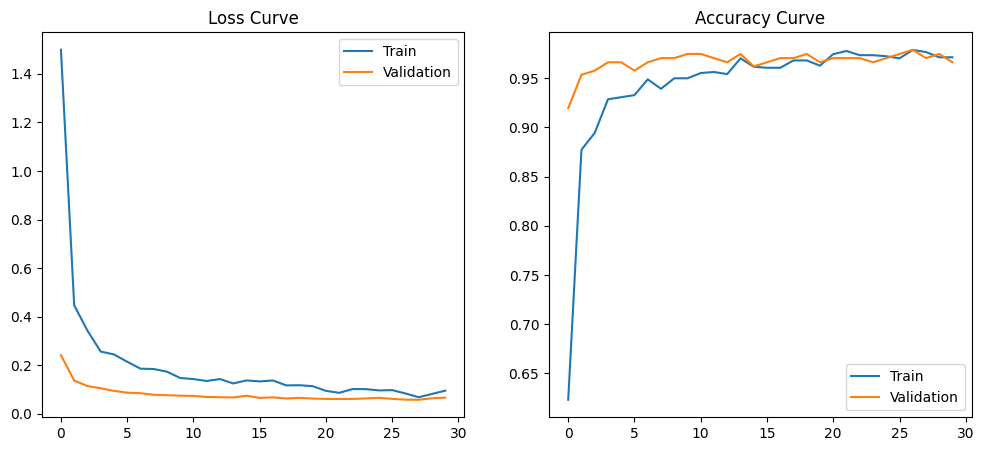

In [11]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Exclude fine-grained classes from primary model evaluation
fine_grained_classes = {2, 12, 13}  # Rusty_Blackbird, American_Crow, Fish_Crow

def compute_non_fine_grained_accuracy(all_preds, all_labels):
    """Compute accuracy excluding fine-grained classes."""
    filtered_preds = [p for p, l in zip(all_preds, all_labels) if l not in fine_grained_classes]
    filtered_labels = [l for l in all_labels if l not in fine_grained_classes]
    if len(filtered_labels) == 0:
        return 0.0  # Prevent division by zero
    return sum(p == l for p, l in zip(filtered_preds, filtered_labels)) / len(filtered_labels)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            with torch.amp.autocast(device_type="cuda"):  # Mixed precision
                outputs = model(images)
                loss = criterion(outputs.logits, labels)
            
            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    
    # Compute non-fine-grained accuracy
    non_fine_grained_acc = compute_non_fine_grained_accuracy(all_preds, all_labels)

    # Compute Precision, Recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=1)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=1)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=1)

    # Print detailed classification report
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))

    return avg_loss, accuracy, non_fine_grained_acc, precision, recall, f1

scaler = torch.amp.GradScaler()
early_stopper = EarlyStopper(patience=10, min_delta=0.0003)
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

# Variables to track the best validation accuracy (excluding fine-grained classes)
best_val_acc = 0.0
best_model_path = "/kaggle/working/best_model.pth"

for epoch in range(30):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc, non_fine_grained_acc, val_precision, val_recall, val_f1 = validate(model, val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    print(f"Epoch {epoch+1:02d}:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} (Overall)")
    print(f"Non-Fine-Grained Acc: {non_fine_grained_acc:.4f} (Used for saving)")
    print(f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1-score: {val_f1:.4f}\n")
    
    if non_fine_grained_acc > best_val_acc:
        best_val_acc = non_fine_grained_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with non-fine-grained validation accuracy: {non_fine_grained_acc:.4f}")
    
    if early_stopper.early_stop(val_loss):
        print("Early stopping triggered!")
        break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

## Save Best Main Model

In [12]:
import os
import torch

# Define the directory where you'll save the best model in Hugging Face format.
save_dir = "/kaggle/working/swin_model"
os.makedirs(save_dir, exist_ok=True)

# Load the best model state dictionary (from the training loop).
best_state_dict = torch.load(best_model_path, map_location=torch.device("cpu"))
model.load_state_dict(best_state_dict)

# Save the best model in Hugging Face format.
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

# Optionally, save additional information such as class mapping and training configuration.
class_info = {
    "class_order": submission_class_order,
    "class_to_idx": train_dataset.class_to_idx,
    "idx_to_class": {v: k for k, v in train_dataset.class_to_idx.items()}
}
torch.save(class_info, os.path.join(save_dir, "class_info.pth"))

train_config = {
    "epochs_trained": len(history['train_loss']),
    "best_val_acc": max(history['val_acc']),
    "optimizer_state": optimizer.state_dict()
}
torch.save(train_config, os.path.join(save_dir, "train_config.pth"))

# Also save the class order as a plain text file for reference.
with open(os.path.join(save_dir, "class_info.txt"), "w") as f:
    f.write("\n".join(submission_class_order))

print(f"Best model saved in Hugging Face format to: {save_dir}")

<ipython-input-12-cf258f9b96a8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load(best_model_path, map_location=torch.device("cpu"))


Best model saved in Hugging Face format to: /kaggle/working/swin_model


# Train the Secondary Model (Rusty_Blackbird, American_Crow, Fish_Crow)

## Filter Dataset for Secondary Model

In [13]:
class FilteredBirdDataset(Dataset):
    """
    A filtered dataset that only contains Rusty_Blackbird (2), American_Crow (12), and Fish_Crow (13).
    """
    def __init__(self, main_dataset, classes_to_keep, transform=None):
        self.dataset = main_dataset  
        self.transform = transform  # Store transform

        # Correct dataset access
        self.indices = [i for i in range(len(main_dataset.samples)) if main_dataset.samples[i][1] in classes_to_keep]
        
        # Remap class labels to range [0, 1, 2]
        self.classes_to_keep = {class_idx: i for i, class_idx in enumerate(classes_to_keep)}
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        image_path, label = self.dataset.samples[self.indices[idx]]  # Fixed

        # Convert image path to an actual image
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            if isinstance(self.transform, A.Compose):  # Albumentations transform
                image = np.array(image)  # Convert PIL image to NumPy
                image = self.transform(image=image)["image"]  # Ensure correct format
            else:  # Torchvision transform
                image = self.transform(image)

        new_label = self.classes_to_keep[label]  # Remap labels to [0, 1, 2]
        return image, new_label

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

albumentations_transform = A.Compose([
    # Basic preprocessing
    A.Resize(height=420, width=420),
    A.RandomResizedCrop(size=(384, 384), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0), 

    # Geometric transformations
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), rotate=(-20, 20), shear=(-10, 10), p=0.7),  

    # Fine-grained texture enhancement
    A.GaussNoise(std_range=(0.01, 0.1), mean_range=(-0.5, 0.5), per_channel=True, noise_scale_factor=1.0, p=0.3),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.8, 1.2), p=0.5),
    A.Emboss(alpha=(0.1, 0.3), strength=(0.3, 0.6), p=0.4),

    # Color and contrast enhancements
    A.MotionBlur(p=0.3),  
    A.CLAHE(p=0.3),  
    A.RandomBrightnessContrast(p=0.4),
    A.HueSaturationValue(hue_shift_limit=12, sat_shift_limit=25, val_shift_limit=12, p=0.4),

    # Patch-Level Occlusion
    A.CoarseDropout(
        num_holes_range=(3, 8),
        hole_height_range=(0.03, 0.12),
        hole_width_range=(0.03, 0.12),
        fill=0,
        p=0.5
    ),

    # Part-Based Attention Regularization
    A.GridDropout(ratio=0.15, p=0.4),
    A.RandomShadow(p=0.3),
    A.RandomRain(p=0.2, brightness_coefficient=0.9, drop_width=1, blur_value=3),

    # Normalize and convert to tensor
    A.Normalize(mean=processor.image_mean, std=processor.image_std),
    ToTensorV2(),
])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-14-d79a1f40cb4e>:16: UserWarning: Argument 'std_range' is not valid and will be ignored.
  A.GaussNoise(std_range=(0.01, 0.1), mean_range=(-0.5, 0.5), per_channel=True, noise_scale_factor=1.0, p=0.3),
<ipython-input-14-d79a1f40cb4e>:16: UserWarning: Argument 'mean_range' is not valid and will be ignored.
  A.GaussNoise(std_range=(0.01, 0.1), mean_range=(-0.5, 0.5), per_channel=True, noise_scale_factor=1.0, p=0.3),
<ipython-input-14-d79a1f40cb4e>:27: UserWarning: Argument 'fill' is not valid and will be ignored.
  A.CoarseDropout(


In [15]:
from timm.data.mixup import Mixup

mixup_fn = Mixup(
    mixup_alpha=0.4, 
    cutmix_alpha=0.4, 
    cutmix_minmax=None, 
    prob=0.7,  # Probability of applying MixUp/CutMix
    switch_prob=0.5,  # Probability of switching between MixUp & CutMix
    mode='batch', 
    label_smoothing=0.1
)

## Create the Secondary Model

In [16]:
secondary_model_name = "Emiel/cub-200-bird-classifier-swin"

id2label = {0: "Rusty_Blackbird", 1: "American_Crow", 2: "Fish_Crow"}
label2id = {v: k for k, v in id2label.items()}

secondary_model = SwinForImageClassification.from_pretrained(
    secondary_model_name,
    num_labels=3,  
    ignore_mismatched_sizes=True,
    id2label=id2label,  
    label2id=label2id
).to(device)

# Freeze backbone & fine-tune only the last block
for param in secondary_model.swin.parameters():
    param.requires_grad = False

if hasattr(secondary_model.swin, "stages"):
    for param in secondary_model.swin.stages[-2].parameters():
        param.requires_grad = True

for param in secondary_model.classifier.parameters():
    param.requires_grad = True

secondary_model.to(device)

print("Secondary model initialized for fine-grained classification.")

Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([3, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Secondary model initialized for fine-grained classification.


## Prepare the Secondary Dataset & Dataloader

In [17]:
fine_grained_classes = [2, 12, 13]  # Only keep Rusty_Blackbird, American_Crow, and Fish_Crow

train_secondary_dataset = FilteredBirdDataset(train_dataset, fine_grained_classes, transform=albumentations_transform)
val_secondary_dataset = FilteredBirdDataset(val_dataset, fine_grained_classes, transform=val_transform)

train_secondary_loader = DataLoader(train_secondary_dataset, batch_size=32, shuffle=True, num_workers=0)
val_secondary_loader = DataLoader(val_secondary_dataset, batch_size=64, shuffle=False, num_workers=0)

# Apply MixUp to Secondary Model Training
for images, labels in train_secondary_loader:
    images, labels = mixup_fn(images, labels)
    break

print(f"Secondary dataset size: Train={len(train_secondary_dataset)}, Validation={len(val_secondary_dataset)}")

Secondary dataset size: Train=143, Validation=36


## Train the Secondary Model

In [18]:
def validate_secondary(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    class_correct = {0: 0, 1: 0, 2: 0}  # Track per-class accuracy
    class_total = {0: 0, 1: 0, 2: 0}  # Track total samples per class
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
                loss = secondary_criterion(outputs.logits, labels)  # Use secondary criterion
            
            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            
            # Track per-class accuracy
            for label, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                class_correct[label] += (pred == label)
                class_total[label] += 1

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)

    # Ensure 5 values are returned
    if len(set(all_labels)) > 1:  # Avoid error if only one class is present
        precision = precision_score(all_labels, all_preds, average="macro", zero_division=1)
        recall = recall_score(all_labels, all_preds, average="macro", zero_division=1)
        f1 = f1_score(all_labels, all_preds, average="macro", zero_division=1)
    else:
        precision, recall, f1 = 0, 0, 0  # Handle edge cases where only one class exists

    # Compute per-class accuracy
    class_accuracy = {cls: class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0 for cls in class_total}

    return avg_loss, accuracy, precision, recall, f1, class_accuracy  # Returns per-class accuracy

In [19]:
# Define optimizer & loss for secondary model
secondary_optimizer = AdamW([
    {"params": secondary_model.swin.parameters(), "lr": 1e-5},
    {"params": secondary_model.classifier.parameters(), "lr": 3e-4}
], weight_decay=0.01)

# secondary_criterion = torch.nn.CrossEntropyLoss()

from collections import Counter

# Count occurrences of each class in the training dataset
train_labels = [label for _, label in train_secondary_dataset]
class_counts = Counter(train_labels)

# Convert to ordered list
num_classes = 3  # You have 3 fine-grained classes
class_counts_list = [class_counts.get(i, 1) for i in range(num_classes)]  # Avoid zero division

# Compute class weights dynamically
total_samples = sum(class_counts_list)
class_weights = [total_samples / (len(class_counts_list) * count) for count in class_counts_list]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use dynamically computed weights for loss function
secondary_criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Training loop for the secondary model
best_secondary_model_path = "/kaggle/working/best_secondary_model.pth"
best_secondary_val_acc = 0.0

secondary_model_save_dir = "/kaggle/working/secondary_swin_model"
os.makedirs(secondary_model_save_dir, exist_ok=True)

for epoch in range(50):  # Train for 50 epochs
    train_loss, train_acc = train_epoch(secondary_model, train_secondary_loader, secondary_optimizer, scaler)
    val_loss, val_acc, val_precision, val_recall, val_f1, class_accuracy = validate_secondary(secondary_model, val_secondary_loader)

    print(f"\n[Secondary Model] Epoch {epoch+1:02d}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1-score: {val_f1:.4f}")

    # Print per-class accuracy
    print("\nPer-Class Accuracy:")
    print(f"  - Rusty_Blackbird (Class 0): {class_accuracy[0]:.4f}")
    print(f"  - American_Crow (Class 1): {class_accuracy[1]:.4f}")
    print(f"  - Fish_Crow (Class 2): {class_accuracy[2]:.4f}")

    # Save the best secondary model
    if val_acc > best_secondary_val_acc:
        best_secondary_val_acc = val_acc
        torch.save(secondary_model.state_dict(), best_secondary_model_path)
        print(f"\nNew best secondary model saved with validation accuracy: {val_acc:.4f}")

        # Save model in Hugging Face format
        secondary_model.save_pretrained(secondary_model_save_dir)
        processor.save_pretrained(secondary_model_save_dir)  # Save processor too

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



[Secondary Model] Epoch 01:
Train Loss: 1.8654 | Train Acc: 0.3007
Val Loss: 1.3427 | Val Acc: 0.3333
Precision: 0.4800 | Recall: 0.3333 | F1-score: 0.2495

Per-Class Accuracy:
  - Rusty_Blackbird (Class 0): 0.0833
  - American_Crow (Class 1): 0.0000
  - Fish_Crow (Class 2): 0.9167

New best secondary model saved with validation accuracy: 0.3333

[Secondary Model] Epoch 02:
Train Loss: 1.1832 | Train Acc: 0.3776
Val Loss: 0.7346 | Val Acc: 0.6667
Precision: 0.6725 | Recall: 0.6667 | F1-score: 0.6528

Per-Class Accuracy:
  - Rusty_Blackbird (Class 0): 0.9167
  - American_Crow (Class 1): 0.7500
  - Fish_Crow (Class 2): 0.3333

New best secondary model saved with validation accuracy: 0.6667

[Secondary Model] Epoch 03:
Train Loss: 0.9005 | Train Acc: 0.6294
Val Loss: 0.5546 | Val Acc: 0.7500
Precision: 0.7675 | Recall: 0.7500 | F1-score: 0.7387

Per-Class Accuracy:
  - Rusty_Blackbird (Class 0): 1.0000
  - American_Crow (Class 1): 0.8333
  - Fish_Crow (Class 2): 0.4167

New best secondar

# Test and Generate Submission File

In [20]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, SwinForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class mapping
submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

# Fine-grained classes requiring secondary classification
fine_grained_classes = {2, 12, 13}  # {Rusty_Blackbird, American_Crow, Fish_Crow}

# Load primary model
primary_model_dir = "/kaggle/working/swin_model"
processor = AutoImageProcessor.from_pretrained(primary_model_dir)
primary_model = SwinForImageClassification.from_pretrained(primary_model_dir).to(device)
primary_model.eval()

# secondary_model = torch.load(best_secondary_model_path, map_location=device)
# secondary_model.to(device)
# secondary_model.eval()
# print("Successfully loaded secondary model from saved checkpoint.")

secondary_model_dir = "/kaggle/working/secondary_swin_model"
processor = AutoImageProcessor.from_pretrained(secondary_model_dir)
secondary_model = SwinForImageClassification.from_pretrained(secondary_model_dir).to(device)
secondary_model.eval()


# Image preprocessing for test data
expected_size = 384
val_transform = transforms.Compose([
    transforms.Resize((expected_size, expected_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Custom dataset class
class CompetitionTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_files = sorted(os.listdir(test_dir))  # Maintain strict order
        self.image_paths = [os.path.join(test_dir, f) for f in self.image_files]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(self.image_paths[idx])

# Function to generate Kaggle submission with Two-Stage Classification
def generate_submission(test_dir, output_csv="submission.csv"):
    test_dataset = CompetitionTestDataset(test_dir, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    filenames = []
    predictions = []

    print(secondary_model.config.id2label)
    
    with torch.no_grad():
        for images, paths in test_loader:
            images = images.to(device)

            # First-stage classification using primary model
            primary_outputs = primary_model(images)
            primary_preds = torch.argmax(primary_outputs.logits, dim=1).cpu().numpy()

            # Identify samples for secondary model
            secondary_indices = [i for i, pred in enumerate(primary_preds) if pred in fine_grained_classes]
            secondary_images = images[secondary_indices]

            if len(secondary_images) > 0:
                # Process fine-grained classes separately
                secondary_outputs = secondary_model(secondary_images)
                secondary_preds = torch.argmax(secondary_outputs.logits, dim=1).cpu().numpy()

                # Map secondary predictions back to global class indices
                fine_grained_class_map = {0: 2, 1: 12, 2: 13}
                remapped_secondary_preds = [fine_grained_class_map[pred] for pred in secondary_preds]


                # Replace primary predictions with secondary ones
                for i, sec_pred in zip(secondary_indices, remapped_secondary_preds):
                    primary_preds[i] = sec_pred

            filenames.extend(paths)
            predictions.extend(primary_preds.tolist())

    # Ensure submission order is respected
    submission_df = pd.DataFrame({'path': filenames, 'class_idx': predictions})

    print("\nValidation Results:")
    print(f"Total Samples: {len(submission_df)}")
    print(f"Number of unique file names: {submission_df['path'].nunique()}")
    print(f"Predicted category distribution:\n{submission_df['class_idx'].value_counts().sort_index()}")

    # Save final submission CSV
    submission_df.to_csv(output_csv, index=False)
    print(f"\nSubmission CSV saved to: {output_csv}")

# Run submission generation
if __name__ == "__main__":
    test_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/CropImage_Dataset/CropImage_Dataset/test_images/mistery_cat"
    generate_submission(test_dir)

{0: 'Rusty_Blackbird', 1: 'American_Crow', 2: 'Fish_Crow'}

Validation Results:
Total Samples: 400
Number of unique file names: 400
Predicted category distribution:
class_idx
0     19
1     16
2     23
3     18
4     22
5     19
6     17
7     19
8     22
9     24
10    20
11    18
12    16
13    23
14    19
15    24
16    20
17    16
18    21
19    24
Name: count, dtype: int64

Submission CSV saved to: submission.csv
